<a href="https://colab.research.google.com/github/amalp12/MLAI/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from google.colab.patches import cv2_imshow
import numpy as np
import pdb # python debugger https://web.stanford.edu/class/physics91si/2013/handouts/Pdb_Commands.pdf
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

**Iniitalizing Hyperparameters**

In [23]:
batch_size = 32
learning_rate = 3e-4
number_of_epochs = 50
noise_dimentions = 64
image_dimentions = 28*28
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))]
)

code = {    "T-Shirt" :0,
            "Trouser" :1,
            "Pullover" :2,
            "Dress" :3,
            "Coat" :4,
            "Sandal" : 5,
            "Shirt" : 6,
            "Sneaker" : 7,
            "Bag" : 8,
            "Boot" :9}

    

r_code = ["T-Shirt",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal" ,
        "Shirt" ,
        "Sneaker" ,
        "Bag" ,
        "Boot",]


**Extra Functions**

In [3]:

# Funtion to Denormalize
def denormalize(x):
  # Denormalizeing 
  pixels =  ((x *.5)+.5)*255
  return pixels
# function to make one hot labels
def labelize(labels, real = True): # labels will be of the form 32x1 we have to make it 32 x 11
  assert type(labels) == torch.Tensor
  labels = labels.reshape(32,1)
  l = torch.zeros((batch_size,10))
  if real:
    for i in range(batch_size):
      l[i][int(labels[i])] = 1
      #l[i][0] =1
  else:
      for i in range(batch_size):
        l[i][int(labels[i])] = 1
        #l[i][0] =0
  return l

# Function to reshape, convert to numpy, denormalize and view image
def show(image):
  assert type(image) == torch.Tensor
  img = image.detach().reshape(28,28)
  img = denormalize(img).numpy()
  cv2_imshow(img)

# fuction to get argmax of disc output that contains 11 nodes tatch_size x11
# step one remove the first column  to make it batch_size x 10
# find and return Argmax
def clothingType(disc_out,string = False):
  assert type(disc_out) == torch.Tensor
  nodes = disc_out
  x = torch.zeros(32,1)
  x = torch.flatten(x)
  for i in range(batch_size):
    x[i] = torch.argmax(nodes[i])
  return x

def plot(samples):
  fig =  plt.figure(figsize = (4,8))
  gs = gridspec.GridSpec(4,8)
  gs.update(wspace = 0.05, hspace =0.05)

  for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('on')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.reshape(28,28), cmap = 'gray')

def show_labels(labels): # for printing 4 x 8 
  labels = labels.detach().reshape(4,8)
  for i in range(4):
    for j in range(8):
      print(r_code[int(labels[i][j].item())], end = ' ')
    print()


**Load Fastion MNIST Dataset**

In [4]:
# Load Dataset
dataset = datasets.FashionMNIST(root="dataset/", transform=transform,download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw




Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw




Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw




Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**View Data**

Dress


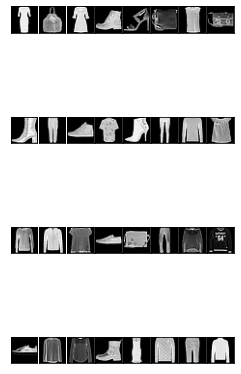

In [5]:

# Samples a batch of data from the dataset 
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Each line of data contains 1 + 28*28*1 integers, the first one is label of the data and the rest are pixels  denoting intensity from 0 to 255
i = None
l = None
for img, labels in test_loader:
  i= img
  l = labels
  break
i = i.reshape(32,28,28).numpy()
i = denormalize(i)
print(r_code[l[0]])
cv2_imshow(i[0])
plot(i)
#pdb.set_trace()

**Loss**

In [6]:
criterion = nn.BCELoss()

**Generator Class**

In [15]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super().__init__()
    self.noise_dim = noise_dim
    self.g_hidden = 256
    self.img_dims = 28*28
    self.learning_rate = 3e-4
    self.model = nn.Sequential(
        nn.Linear(self.noise_dim +10,self.g_hidden),
        nn.LeakyReLU(0.1),
        nn.Linear(self.g_hidden, self.g_hidden),
        nn.LeakyReLU(0.1),
        nn.Linear(self.g_hidden, self.img_dims ),
        nn.Tanh(), # to ensure output b/w -1 and 1 inclusive
            )

    self.optimizer = optim.Adam(params= self.parameters(), lr= self.learning_rate)

  def forward(self, noise , labels):
      x = torch.cat((noise, labels), dim=1) # to be confirmed
      return self.model(x)

gen = Generator(noise_dimentions)

**Discriminator Class**

In [16]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.img_dims = 28*28
    self.d_hidden = 128
    self.learning_rate = 3e-4
    self.model = nn.Sequential(
      nn.Linear(self.img_dims, self.d_hidden),
      nn.LeakyReLU(0.1),
      nn.Linear(self.d_hidden, self.d_hidden), # 10 for   labels
      nn.LeakyReLU(0.1),
      nn.Linear(self.d_hidden, 10),
      nn.Sigmoid()
    )
    self.optimizer = optim.Adam(self.parameters() , lr = self.learning_rate )
  def forward(self,x):
    return self.model(x)

disc = Discriminator()

**Training**

Epoch [0/50] Batch 0/1875                       Loss D: 0.0801, loss G: 0.1235
Real Images: 
Bag T-Shirt Trouser Sneaker Sneaker T-Shirt Bag Trouser 
Boot Dress Bag T-Shirt Sandal Coat Bag Pullover 
Boot T-Shirt Bag Dress T-Shirt Trouser Shirt Trouser 
T-Shirt Sneaker Bag T-Shirt Shirt Coat Pullover Shirt 
Fake Images: 
Bag T-Shirt Trouser Sneaker Sneaker T-Shirt Bag Trouser 
Boot Dress Bag T-Shirt Sandal Coat Bag Pullover 
Boot T-Shirt Bag Dress T-Shirt Trouser Shirt Trouser 
T-Shirt Sneaker Bag T-Shirt Shirt Coat Pullover Shirt 
Epoch [1/50] Batch 0/1875                       Loss D: 0.0937, loss G: 0.0964
Real Images: 
Bag Sneaker Trouser Shirt Trouser Dress T-Shirt Dress 
Trouser Pullover Pullover Sneaker Trouser Coat Sneaker Dress 
Sandal Boot Coat Sandal Coat Boot Dress Pullover 
Coat Boot Bag Pullover Bag Sneaker Boot Sandal 
Fake Images: 
Bag Sneaker Trouser Shirt Trouser Dress T-Shirt Dress 
Trouser Pullover Pullover Sneaker Trouser Coat Sneaker Dress 
Sandal Boot Coat Sandal 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Bag Shirt T-Shirt Coat Boot Dress Trouser Coat 
T-Shirt Trouser Coat Trouser Pullover Coat Coat Shirt 
Sneaker Bag Pullover T-Shirt T-Shirt Trouser Sandal Dress 
Dress Shirt Trouser Coat T-Shirt Shirt Sandal Sneaker 
Fake Images: 
Bag Shirt T-Shirt Coat Boot Dress Trouser Coat 
T-Shirt Trouser Coat Trouser Pullover Coat Coat Shirt 
Sneaker Bag Pullover T-Shirt T-Shirt Trouser Sandal Dress 
Dress Shirt Trouser Coat T-Shirt Shirt Sandal Sneaker 
Epoch [11/50] Batch 0/1875                       Loss D: 0.0885, loss G: 0.1057
Real Images: 
Sandal Shirt Bag Sneaker Dress Bag Shirt Dress 
Bag Dress Shirt Shirt Trouser Dress Bag Sandal 
Pullover Shirt Boot Shirt T-Shirt Trouser Coat Dress 
Pullover Coat Sandal Trouser Bag Boot Dress Bag 
Fake Images: 
Sandal Shirt Bag Sneaker Dress Bag Shirt Dress 
Bag Dress Shirt Shirt Trouser Dress Bag Sandal 
Pullover Shirt Boot Shirt T-Shirt Trouser Coat Dress 
Pullover Coat Sandal Trouser Bag Boot Dress Bag 
Epoch [12/50] Batch 0/1875                    

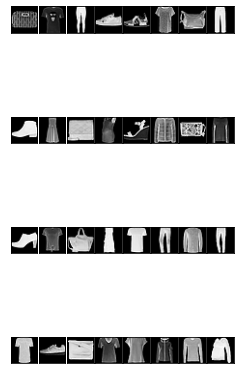

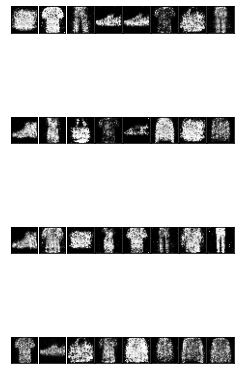

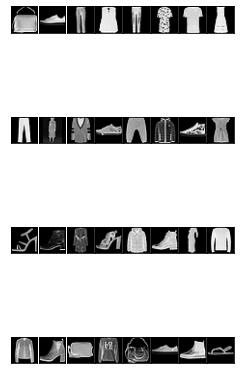

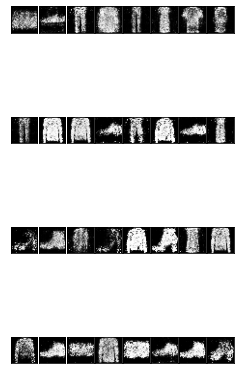

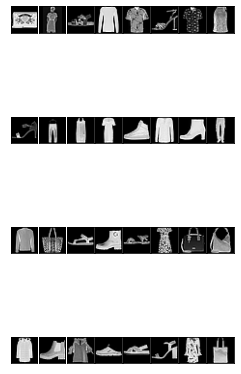

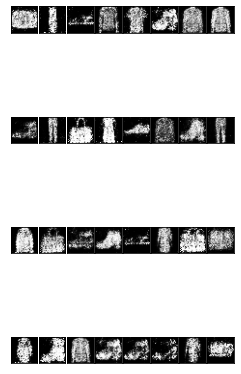

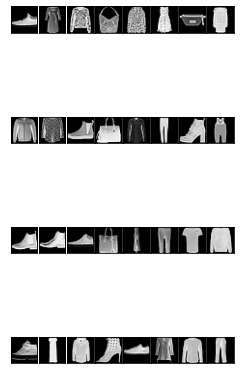

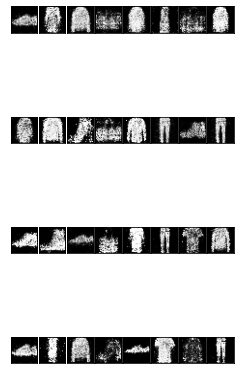

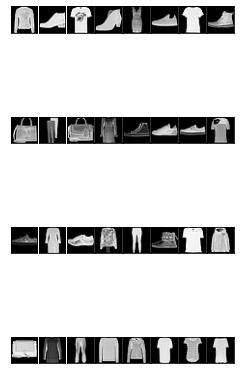

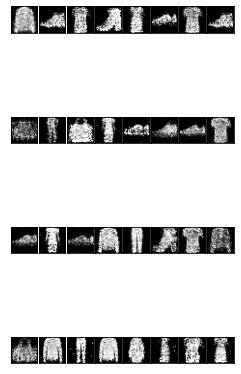

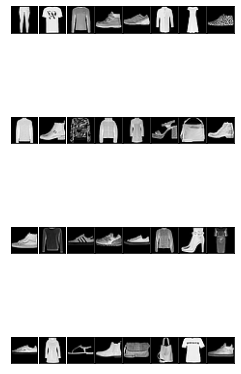

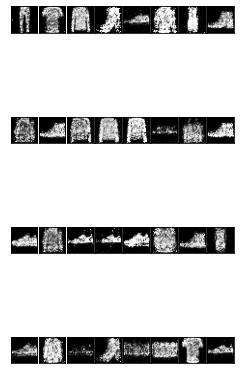

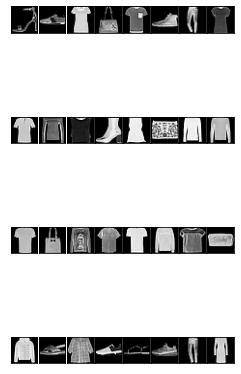

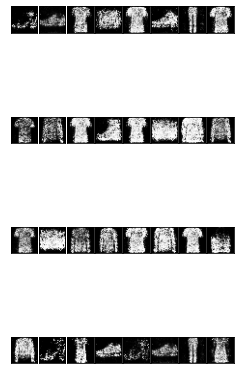

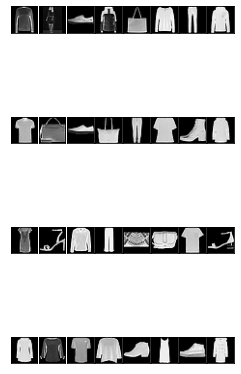

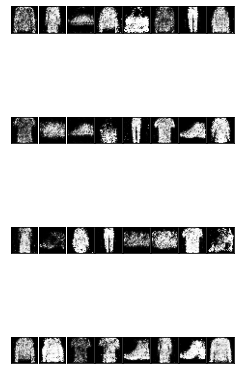

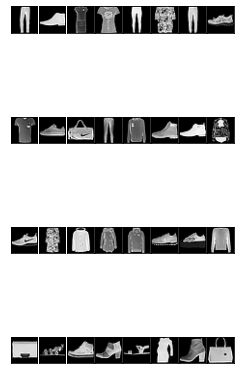

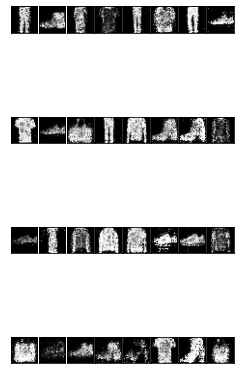

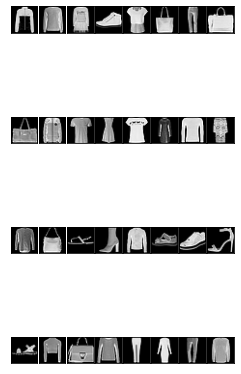

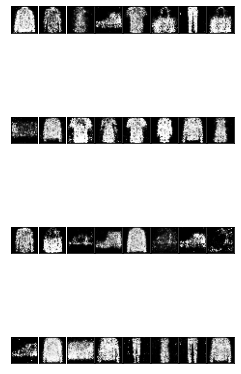

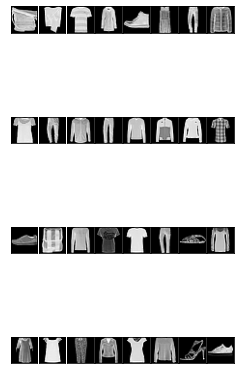

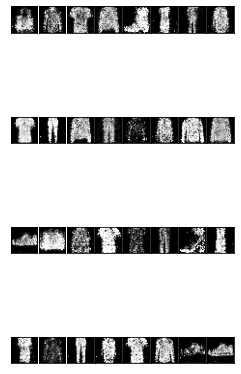

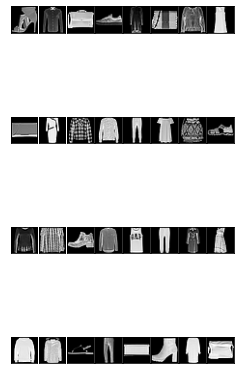

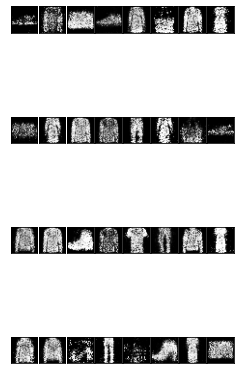

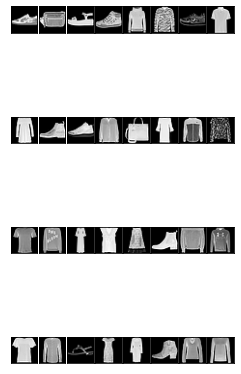

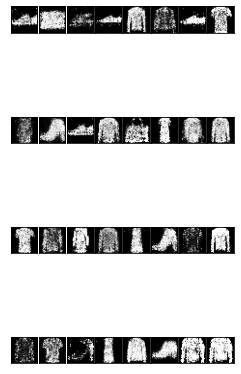

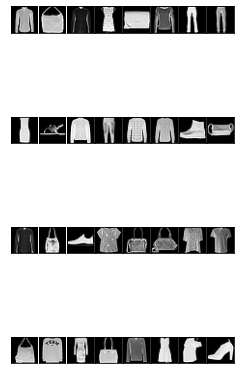

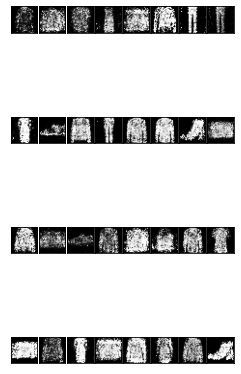

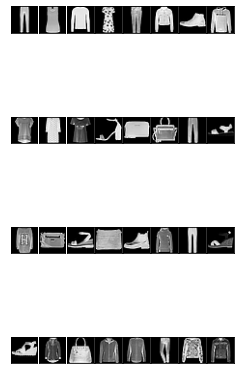

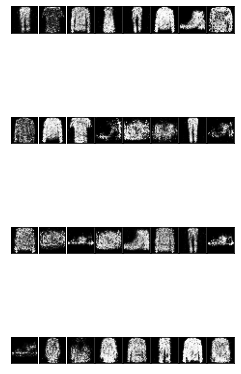

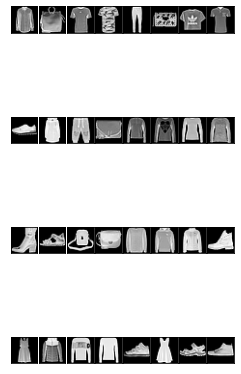

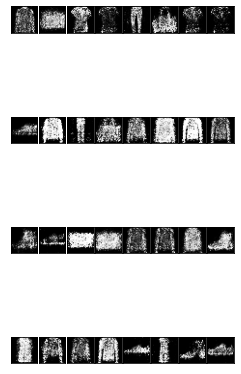

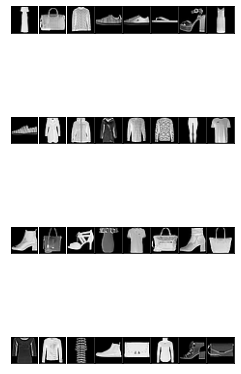

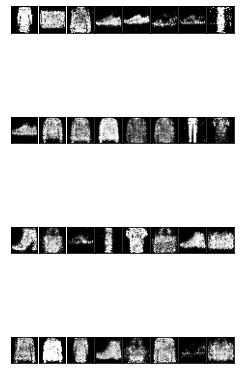

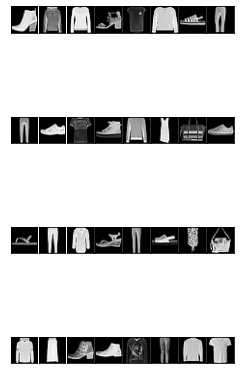

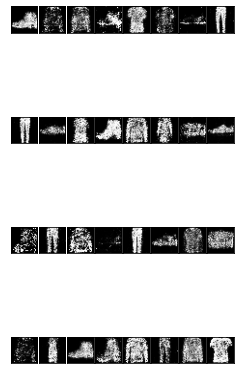

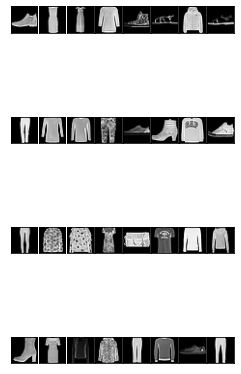

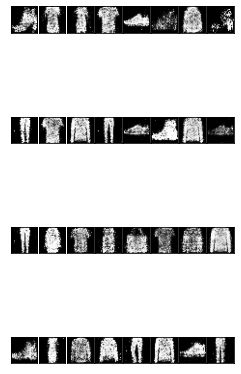

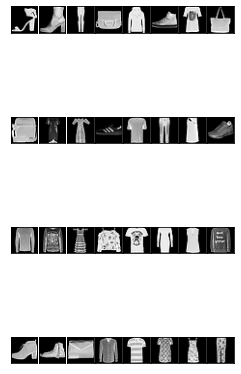

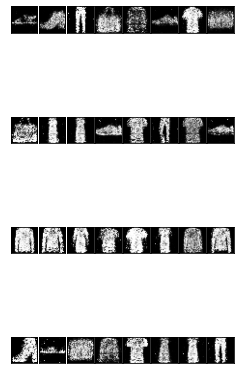

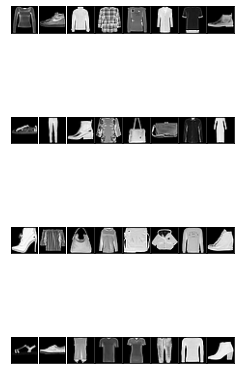

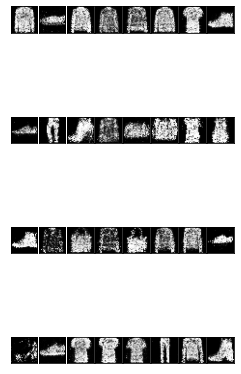

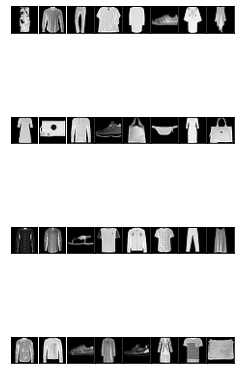

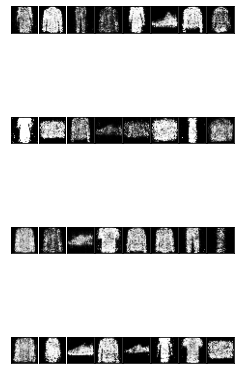

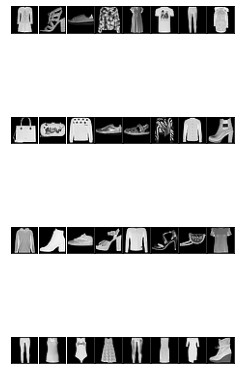

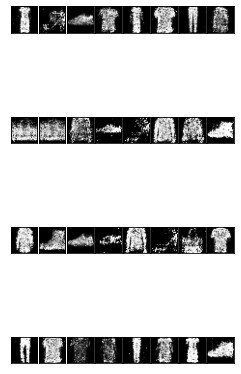

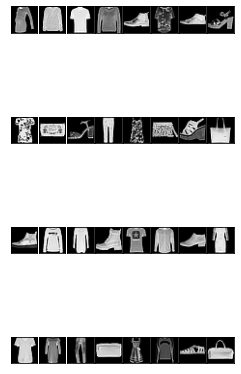

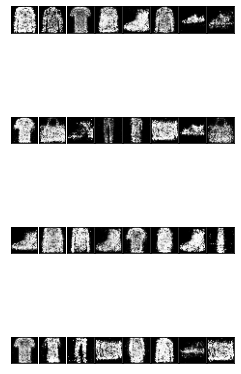

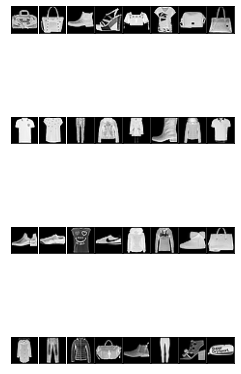

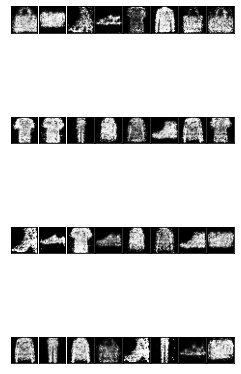

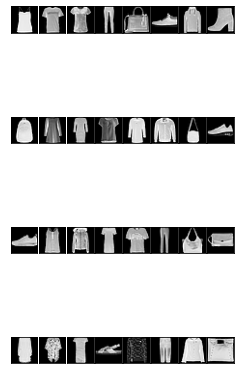

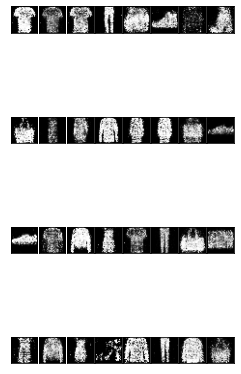

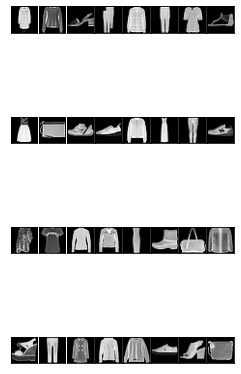

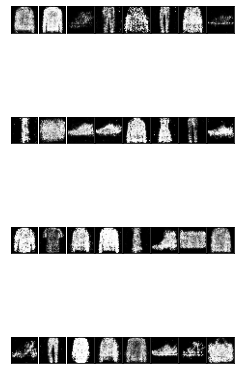

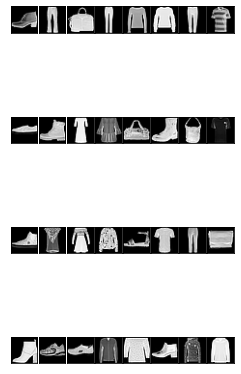

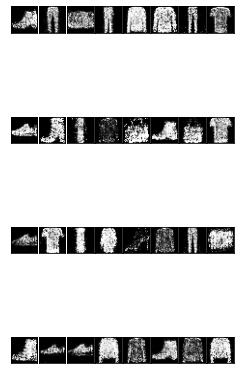

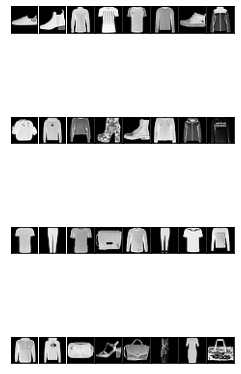

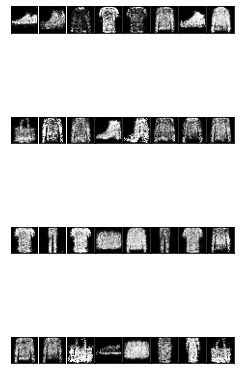

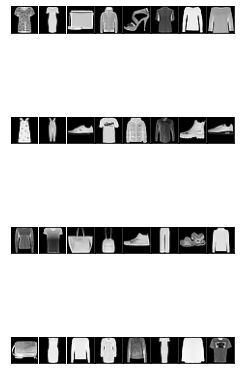

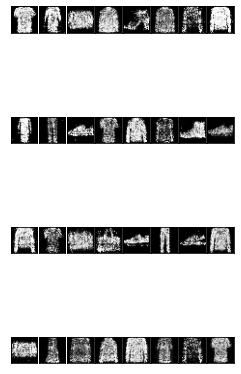

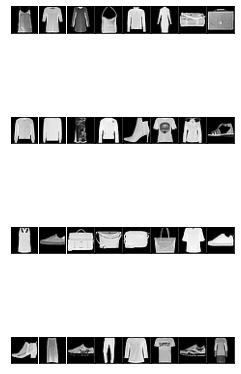

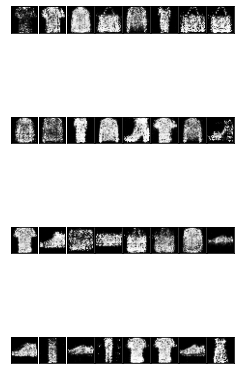

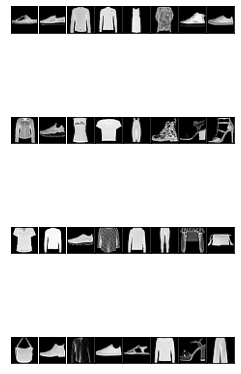

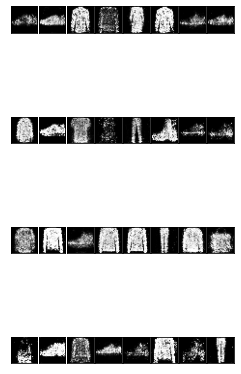

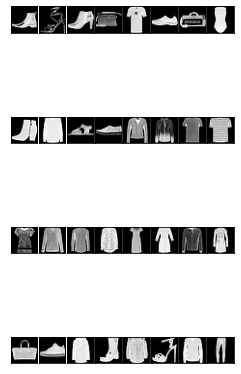

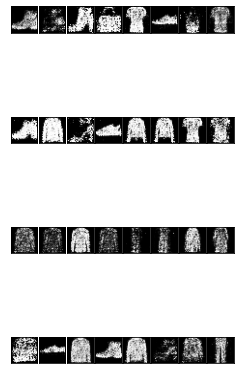

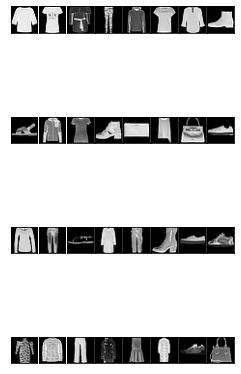

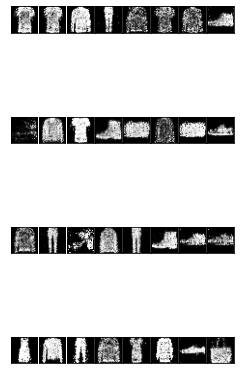

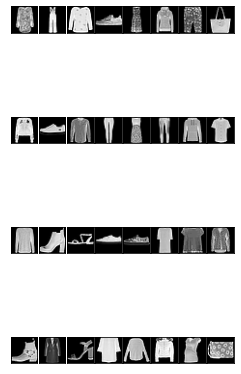

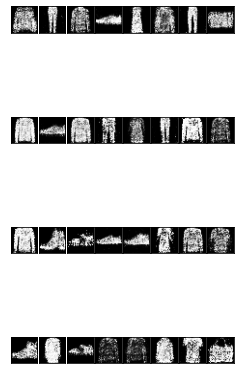

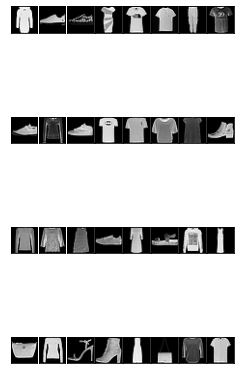

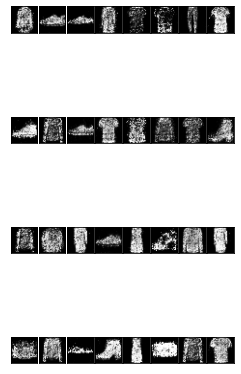

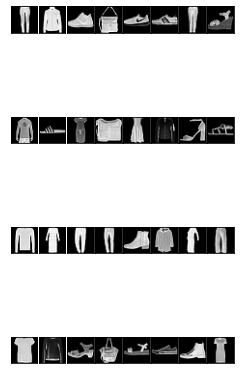

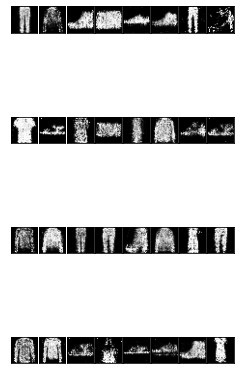

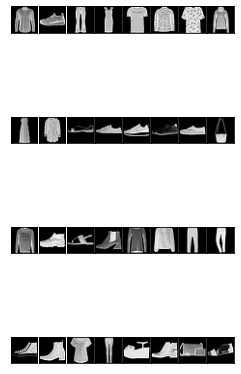

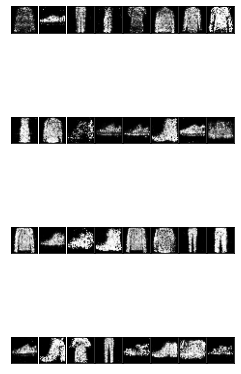

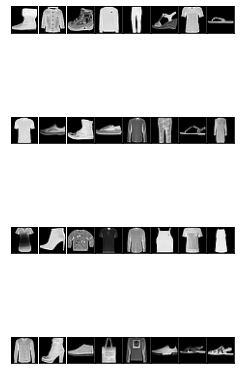

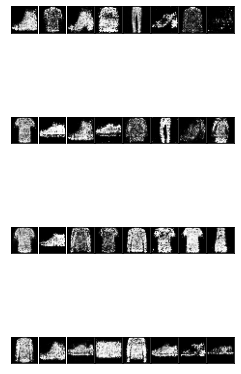

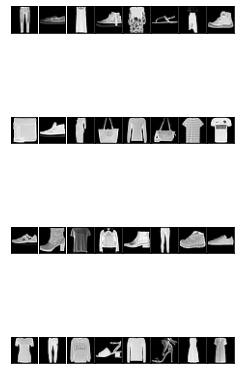

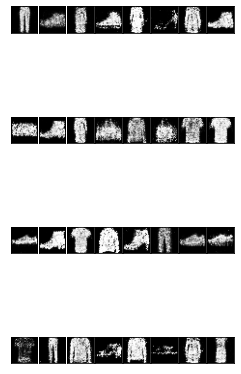

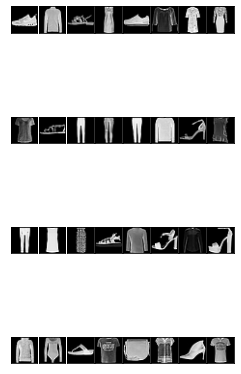

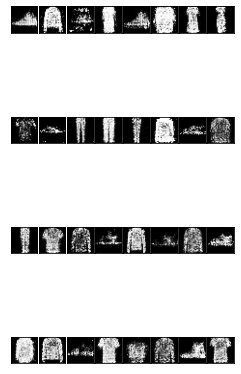

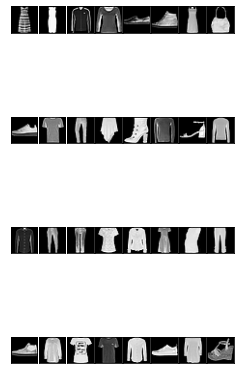

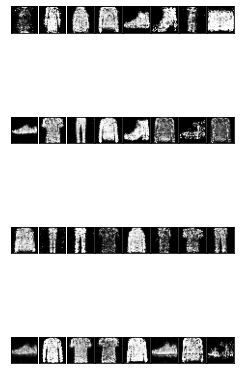

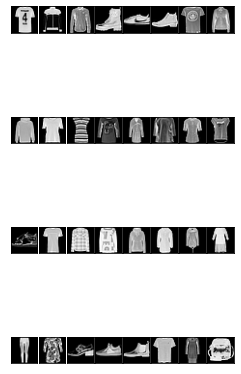

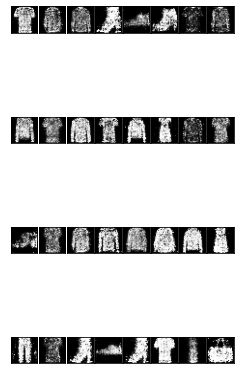

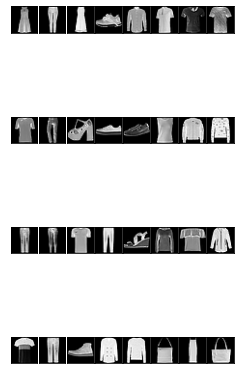

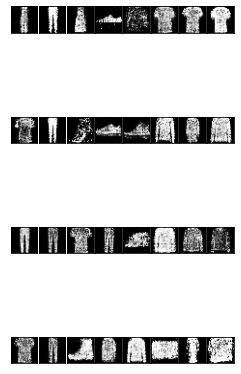

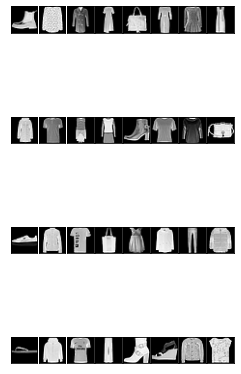

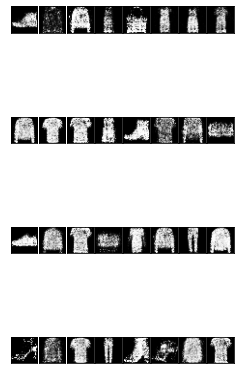

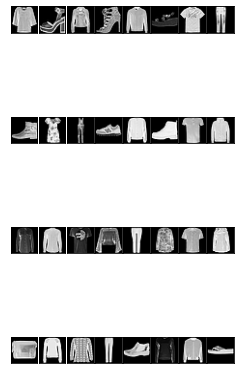

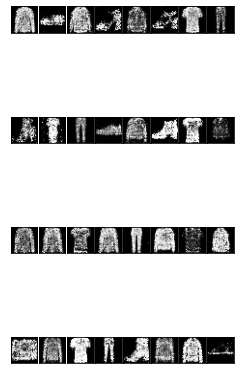

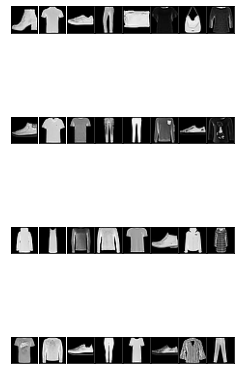

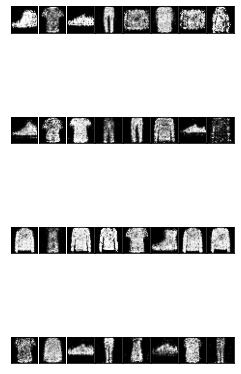

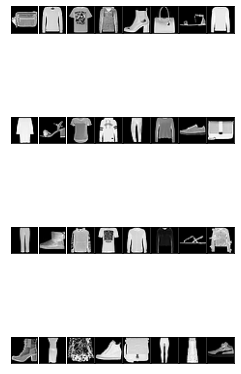

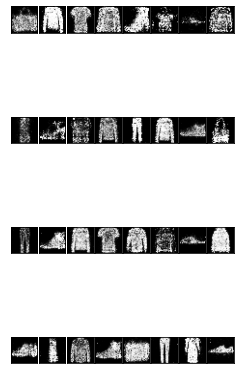

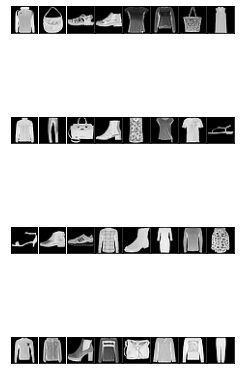

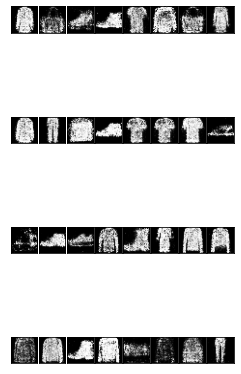

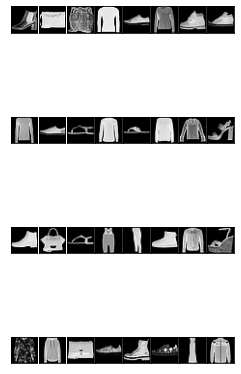

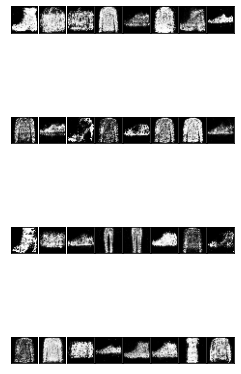

In [27]:
for epoch in range(number_of_epochs):
  for batch_index , (real_img, labels) in enumerate(loader):
    
    # Preprocess
    real_img = real_img.reshape(32,28,28)
    flat_rimg = torch.flatten(real_img,start_dim=1)

    
    #### Train Discirminator
    
    disc_rout = disc(flat_rimg) # outputs 11 sigmoid notes , first one says real or fake the next tells cateogory
    r_labels = labelize(labels, real = True)  


    disc_real_loss = criterion(disc_rout,  r_labels)


    # Getting fake images from Generator
    noise = torch.randn(batch_size, noise_dimentions ) # torch.Size([32, 64])
    #f_labels = torch.zeros(32,10) # fake labels torch.Size([batch_size, 10])
                              
    # takes in random noise 32 x noise_dim  + random label 32 x 10 = 32 x (noisedim + 10)
    fake_img = gen(noise, r_labels.detach()) # torch.Size([32, 784]) # will be reusd for generators, hence retain graph
    # show(fake_img[16]) Test Line
    
    disc_fout = disc(fake_img) # torch.Size([32, 11])  outputs 11 sigmoid notes , first one says real or fake the next tells cateogory
    f_out_labels = clothingType(disc_fout.detach())
    disc_fakes_loss = criterion(disc_fout, torch.zeros(32,10))
    
    # average fake and real loss
    disc_loss = (disc_real_loss + disc_fakes_loss) / 2

    disc.zero_grad() # clearing disc gradients
    # when we use loss.backward(), everything we used to calculate the gradients will be cleared, if we do not want that to happen then use retain graph
    disc_loss.backward(retain_graph = True) # retained because we need to reuse fake_images
    disc.optimizer.step()

    
    #### Training Generator
    # Getting fake image outputs, when passed through the trained generator
    trained_disc_outputs = disc(fake_img) # disc says whether its real or fake, at first index (1,0), if zero rest are don't cares
    # we actually want the generator to approach 1 for all the first column in the disriminators test
    # hence the loss will be (trained disc output, all ones in the first column)
    gen_target = labelize(labels, real = True)     
    gen_loss = criterion( trained_disc_outputs, gen_target)
    #pdb.set_trace()
    gen.zero_grad()
    gen_loss.backward()
    gen.optimizer.step()
   
    if batch_index == 0:
            print(
                f"Epoch [{epoch}/{number_of_epochs}] Batch {batch_index}/{len(loader)} \
                      Loss D: {disc_loss:.4f}, loss G: {gen_loss:.4f}"
            )

            with torch.no_grad():
                random_noise = torch.randn((batch_size, noise_dimentions))
                fake = gen(random_noise, r_labels)
                data = real_img
              
                #pdb.set_trace()
                print(f"Real Images: ")
                plot(data)
                show_labels(labels)
                #pdb.set_trace()
                print(f"Fake Images: ")
                plot(fake)         
                show_labels(f_out_labels)


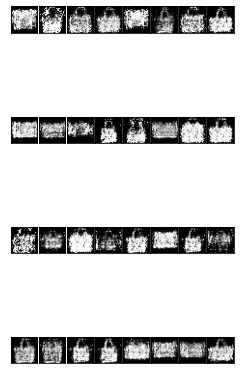

In [36]:
#"T-Shirt" :0,            "Trouser" :1,            "Pullover" :2,
#"Dress" :3,            "Coat" :4,            "Sandal" : 5,
#"Shirt" : 6,            "Sneaker" : 7,            "Bag" : 8,            "Boot" :9}
word = "Bag"
# Getting fake images from Generator
t_noise = torch.randn(batch_size, noise_dimentions)# torch.Size([32, 64])
t_labels = torch.ones(32,1) *code[word]  # fake labels torch.Size([32, 11])
t_labels = labelize(t_labels)
#pdb.set_trace()                        
# takes in random noise 32 x noise_dim  + random label 32 x 10 = 32 x (noisedim + 10)
t_fake_img = gen(t_noise, t_labels) # torch.Size([32, 784]) 

plot(t_fake_img.detach())  